In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import metrics
from time import time
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [2]:
df = pd.read_excel('customer_churn.xlsx')

In [3]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,Competitor had better devices


# Cleaning

In [4]:
 df.columns = (df.columns
               .str.replace('\s','_',regex=True)
               .str.lower()
               .copy()
               )

In [5]:
## All these have been checked to be binary first

df.gender = df.gender.map({'Male':0,'Female':1})
df.senior_citizen = df.senior_citizen.map({'No':0,'Yes':1})
df.partner = df.partner.map({'No':0,'Yes':1})
df.dependents = df.dependents.map({'No':0,'Yes':1})
df.phone_service = df.phone_service.map({'No':0,'Yes':1})
df.paperless_billing = df.paperless_billing.map({'No':0,'Yes':1})

## Rename gender to sex
df.rename(columns={'gender':'sex'},inplace=True)

In [6]:
## One hot encode a number of columns

df=pd.get_dummies(data = df, columns = ['multiple_lines','internet_service','online_security','online_backup','device_protection','tech_support','streaming_movies','streaming_tv','contract','payment_method'], drop_first=True)

# Split

In [7]:
## Feature columns

Features = [
    'tenure_months',
    'internet_service_Fiber optic',
    'contract_Two year',
    'payment_method_Electronic check',
    'dependents',
    'streaming_movies_No internet service',
    'device_protection_No internet service',
    'online_security_No internet service',
    'internet_service_No',
    'online_backup_No internet service',
    'churn_value'
]

In [8]:
## Create X & y

X=df[Features].copy()

y= X['churn_value']

X.drop(columns=['churn_value'], inplace=True)

In [9]:
## Create train & test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Decision Trees

### Class Weights

In [10]:
# Calculate class weights
total_samples = len(df)
class_0_count = 5174
class_1_count = 1869
class_0_weight = total_samples / class_0_count
class_1_weight = total_samples / class_1_count

# Create a dictionary with the class weights
class_weights = {0: class_0_weight, 1: class_1_weight}

### Hyperparameters

In [11]:
grid = GridSearchCV(estimator = DecisionTreeClassifier(), ## classifier/algorithm (in this case DT)
                    param_grid = {'max_depth': [3, 5, 7, 10], ## How many levels can I go
                                  'min_samples_split': [5, 10, 15, 20, 50, 100], ## How many samples needed in a node for me to split
                                  'min_samples_leaf': [2, 3, 4, 5, 6, 7],  ##  How many samples needed in a node to call it a terminal/leaf
                                  'max_features':[2,5]},  ##How many features can I use from the data
                    cv = 10, ##Number of cross validation folds, how much to split the data, so for each interation  of the process it removes on of those segments & runs the process without it
                    refit = True, ##What do I do for each fold?
                    verbose = 1, ## Avaliable options are 0,1,2 (least to most verbose), how much it tells you
                    scoring = 'accuracy') ##What performance metric to priotise?

In [12]:
# We run the gridsearch

#Set the current time from your local machine
now = time()

## Run the gridsearch
grid.fit(X_train, y_train)

##Subtract the 'now' time from the current time
print(f' Time in seconds: {time() - now}')


Fitting 10 folds for each of 288 candidates, totalling 2880 fits
 Time in seconds: 44.234885931015015


In [13]:
grid.best_params_

{'max_depth': 7,
 'max_features': 5,
 'min_samples_leaf': 7,
 'min_samples_split': 5}

In [14]:
grid.best_score_

0.7983557562702341

In [15]:
grid.best_estimator_

DecisionTreeClassifier(max_depth=7, max_features=5, min_samples_leaf=7,
                       min_samples_split=5)

In [16]:
dt = DecisionTreeClassifier(max_depth=7, min_samples_leaf=7, min_samples_split=50,class_weight=class_weights)

In [17]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1.3612292230382683,
                                     1: 3.7683253076511503},
                       max_depth=7, min_samples_leaf=7, min_samples_split=50)

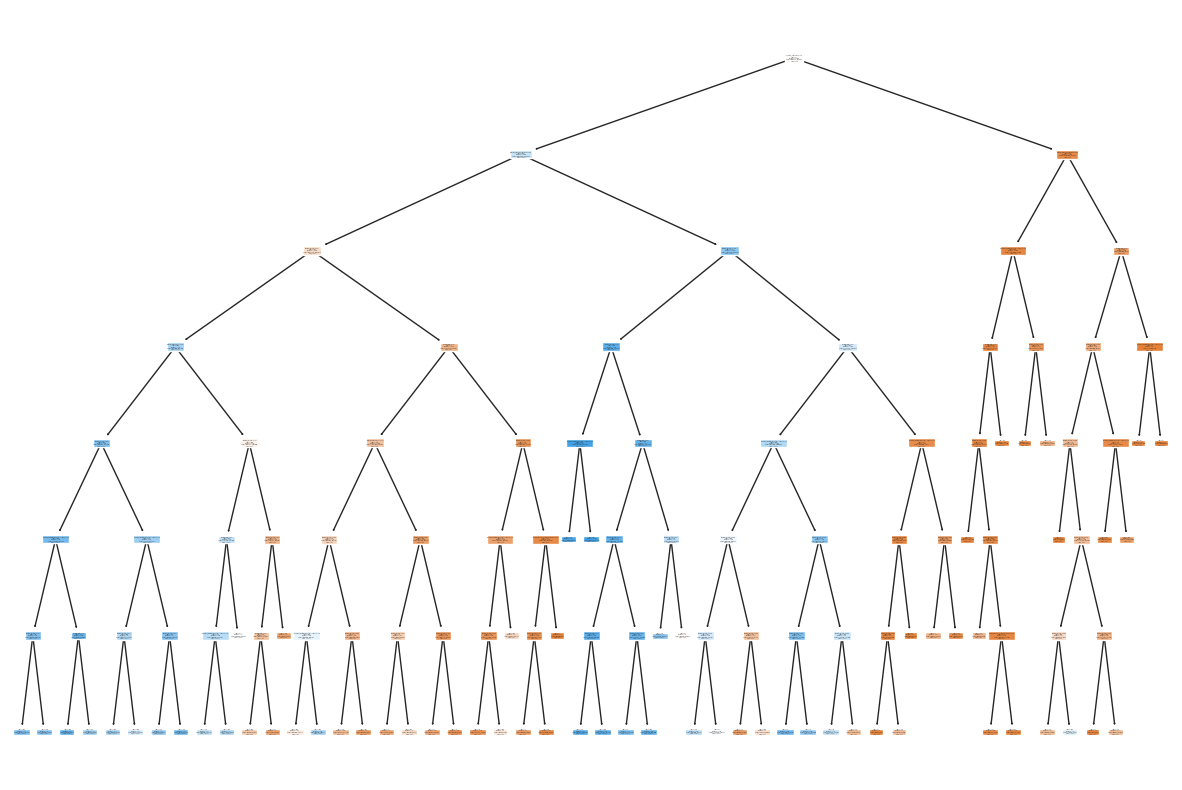

In [18]:
fig = plt.figure(figsize=(15,10))
thing = tree.plot_tree(dt,
                       feature_names=X_train.columns,
                       class_names=['not', 'churn'],
                       filled=True)

# Evaluate

In [19]:
# Evaluate model.
print(f'Score on training set: {dt.score(X_train, y_train)}')
print(f'Score on testing set: {dt.score(X_test, y_test)}')

Score on training set: 0.7554135605253817
Score on testing set: 0.7530163236337828


In [20]:
# predictions on X_train
train_results = X_train.copy()
train_results['y_pred'] = dt.predict(X_train)
train_results['y_real'] = y_train
train_results['y_prob'] = dt.predict_proba(X_train)[:,1]

In [21]:
# X_test

test_results = X_test.copy()
test_results['y_pred'] = dt.predict(X_test)
test_results['y_real'] = y_test
test_results['y_prob'] = dt.predict_proba(X_test)[:,1]

### Confusion Matrix

In [22]:
def conf_matrix(matrix):
    ax = plt.subplot()
    sns.heatmap(matrix, annot = True, ax = ax, fmt = 'g');
    ax.xaxis.set_ticklabels(['predicted negative', 'predicted positive'])
    ax.yaxis.set_ticklabels(['actual negative', 'actual positive']);

In [23]:
con_results=metrics.confusion_matrix(y_test,test_results['y_pred'])

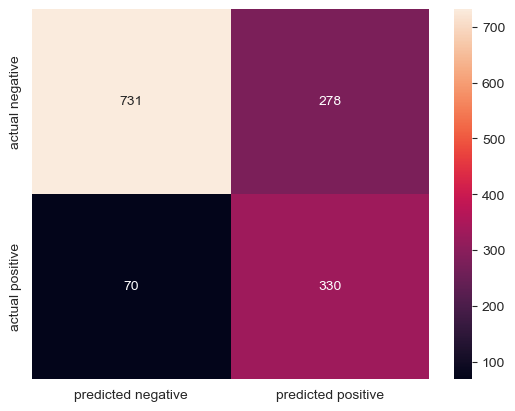

In [24]:
conf_matrix(con_results)

In [25]:
## Train

print(metrics.classification_report(y_train,train_results['y_pred']))

              precision    recall  f1-score   support

           0       0.93      0.72      0.81      4165
           1       0.52      0.84      0.64      1469

    accuracy                           0.76      5634
   macro avg       0.72      0.78      0.73      5634
weighted avg       0.82      0.76      0.77      5634



In [26]:
## Test

print(metrics.classification_report(y_test,test_results['y_pred']))

              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1009
           1       0.54      0.82      0.65       400

    accuracy                           0.75      1409
   macro avg       0.73      0.77      0.73      1409
weighted avg       0.81      0.75      0.76      1409



In [27]:
def get_results(actual, predicted):
    print("The confusion matrix for your predictions is:")
    print(metrics.confusion_matrix(actual, predicted), "\n")
    print(f'The accuracy of your model is: {metrics.accuracy_score(actual, predicted)}')
    print(f'The recall of your model is: {metrics.recall_score(actual, predicted)}')
    print(f'The precision of your model is: {metrics.precision_score(actual, predicted)}')
    print(f'The F1-score of your model is: {metrics.f1_score(actual, predicted)}')

In [28]:
## Train

get_results(y_train, train_results['y_pred'])

The confusion matrix for your predictions is:
[[3017 1148]
 [ 230 1239]] 

The accuracy of your model is: 0.7554135605253817
The recall of your model is: 0.8434309053778081
The precision of your model is: 0.5190615835777126
The F1-score of your model is: 0.6426348547717843


In [29]:
## Test
get_results(y_test, test_results['y_pred'])

The confusion matrix for your predictions is:
[[731 278]
 [ 70 330]] 

The accuracy of your model is: 0.7530163236337828
The recall of your model is: 0.825
The precision of your model is: 0.5427631578947368
The F1-score of your model is: 0.6547619047619047


# CSV Creation

### CSV Prep

In [30]:
DT_train_y=train_results[['y_prob']]
DT_test_y=test_results[['y_prob']]
all_ID=df[['customerid','churn_value']]

In [31]:
DT_all_y=pd.concat([DT_train_y,DT_test_y])

In [32]:
DT_all_y=DT_all_y.join(all_ID)

In [33]:
DT_all_y.head()

,y_prob,customerid,churn_value
2142,0.425788,9571-EDEBV,0
1623,0.829128,7562-GSUHK,1
6074,0.603436,2325-WINES,0
1362,0.306967,9381-NDKME,1
6754,0.099694,2164-SOQXL,0


### Top500

In [62]:
DT_top_churn=DT_all_y[DT_all_y.churn_value==0].sort_values(['y_prob'],ascending=False).head(500)

In [66]:
DT_top_churn[['customerid']].to_csv("project_4_DT_results.csv",index=False)

In [36]:
DT_top_churn.head()

,y_prob,customerid,churn_value
4327,0.958132,5043-TRZWM,0
5657,0.958132,7577-SWIFR,0
5820,0.958132,4273-MBHYA,0
4030,0.958132,5542-TBBWB,0
3796,0.958132,2262-SLNVK,0


### Remainder

In [64]:
DT_remainder=DT_all_y[DT_all_y.churn_value==0].sort_values(['y_prob'],ascending=False)

In [67]:
DT_remainder[['customerid','y_prob']].to_csv("project_4_DT_remainder.csv",index=False)

# Random Forests

## Fit the model

In [39]:
## Random forests & extra randomised trees

rf = RandomForestClassifier(n_estimators=50,class_weight=class_weights)
et = ExtraTreesClassifier(n_estimators=50,class_weight=class_weights)

In [40]:
##generate cross validation scores for both

rf_score = cross_val_score(rf, X_train, y_train, cv=5)
et_score = cross_val_score(et, X_train, y_train, cv=5)

In [41]:
##print them out

print(f'Random scored {rf_score}')
print(f'Extra Random scored {et_score}')

Random scored [0.75865129 0.75598935 0.74090506 0.71606034 0.75843694]
Extra Random scored [0.74267968 0.74090506 0.73203194 0.70008873 0.74067496]


In [42]:
## Run another grid search on random forests

rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
}


gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=1) ##Grid search

gs.fit(X_train, y_train) ## Fit on the train

print(gs.best_score_)

gs.best_params_ ## Get the best parameters

Fitting 5 folds for each of 18 candidates, totalling 90 fits
0.7461857428120682


{'max_depth': None, 'n_estimators': 100}

### Accuracy Score

In [43]:
##Look at the accuracy

gs.score(X_train, y_train)

0.7847000354987576

In [44]:
gs.score(X_test,y_test)

0.7423704755145494

### Predict

In [45]:
# predictions on X_train
RF_train_results = X_train.copy()
RF_train_results['y_pred'] = gs.predict(X_train)
RF_train_results['y_real'] = y_train
RF_train_results['y_prob'] = gs.predict_proba(X_train)[:,1]

RF_train_results.head()

,tenure_months,internet_service_Fiber optic,contract_Two year,payment_method_Electronic check,dependents,streaming_movies_No internet service,device_protection_No internet service,online_security_No internet service,internet_service_No,online_backup_No internet service,y_pred,y_real,y_prob
2142,71,1,0,0,0,0,0,0,0,0,0,0,0.000000
1623,16,1,0,0,0,0,0,0,0,0,1,1,0.729747
6074,32,1,0,0,0,0,0,0,0,0,1,0,0.761356
1362,24,0,0,0,0,0,0,0,0,0,0,1,0.415407
6754,20,0,0,0,1,1,1,1,1,1,0,0,0.000000


In [46]:
# X_test

RF_test_results = X_test.copy()
RF_test_results['y_pred'] = gs.predict(X_test)
RF_test_results['y_real'] = y_test
RF_test_results['y_prob'] = gs.predict_proba(X_test)[:,1]

RF_test_results.head()

,tenure_months,internet_service_Fiber optic,contract_Two year,payment_method_Electronic check,dependents,streaming_movies_No internet service,device_protection_No internet service,online_security_No internet service,internet_service_No,online_backup_No internet service,y_pred,y_real,y_prob
185,15,1,0,0,0,0,0,0,0,0,1,1,0.667753
2715,18,0,0,0,0,0,0,0,0,0,0,0,0.431452
3825,2,0,0,0,0,1,1,1,1,1,0,0,0.335967
1807,6,1,0,1,0,0,0,0,0,0,1,1,0.829534
132,40,1,0,0,0,0,0,0,0,0,1,1,0.617657


### Confusion Matrix

In [47]:
RF_con_results=metrics.confusion_matrix(y_test,RF_test_results['y_pred'])

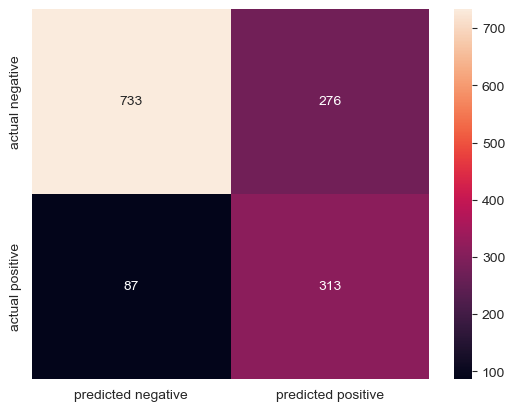

In [48]:
conf_matrix(RF_con_results)

In [49]:
## Train

print(metrics.classification_report(y_train,RF_train_results['y_pred']))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84      4165
           1       0.56      0.86      0.68      1469

    accuracy                           0.78      5634
   macro avg       0.75      0.81      0.76      5634
weighted avg       0.84      0.78      0.80      5634



In [50]:
## Test

print(metrics.classification_report(y_test,RF_test_results['y_pred']))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1009
           1       0.53      0.78      0.63       400

    accuracy                           0.74      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.74      0.75      1409



In [51]:
## Train

get_results(y_train, RF_train_results['y_pred'])

The confusion matrix for your predictions is:
[[3157 1008]
 [ 205 1264]] 

The accuracy of your model is: 0.7847000354987576
The recall of your model is: 0.8604492852280463
The precision of your model is: 0.5563380281690141
The F1-score of your model is: 0.6757551456829725


In [52]:
## Test
get_results(y_test, RF_test_results['y_pred'])

The confusion matrix for your predictions is:
[[733 276]
 [ 87 313]] 

The accuracy of your model is: 0.7423704755145494
The recall of your model is: 0.7825
The precision of your model is: 0.5314091680814941
The F1-score of your model is: 0.6329625884732052


# CSV's Prep

In [53]:
RF_train_y=RF_train_results[['y_prob']]
RF_test_y=RF_test_results[['y_prob']]
all_ID=df[['customerid','churn_value']]

In [54]:
RF_all_y=pd.concat([RF_train_y,RF_test_y])

In [55]:
RF_all_y=RF_all_y.join(all_ID)

In [56]:
RF_all_y.head()

,y_prob,customerid,churn_value
2142,0.000000,9571-EDEBV,0
1623,0.729747,7562-GSUHK,1
6074,0.761356,2325-WINES,0
1362,0.415407,9381-NDKME,1
6754,0.000000,2164-SOQXL,0


### Top 500 (top_churn) as CSV

In [57]:
RF_top_churn=RF_all_y[RF_all_y.churn_value==0].sort_values(['y_prob'],ascending=False).head(500)

In [58]:
RF_top_churn[['customerid']].to_csv("project_4_RF_results.csv",index=False)

In [59]:
RF_top_churn.head()

,y_prob,customerid,churn_value
3518,0.962294,1393-IMKZG,0
2215,0.962294,1452-VOQCH,0
3364,0.962294,8775-ERLNB,0
6353,0.962294,9605-WGJVW,0
5676,0.962294,9840-EFJQB,0


### Remainder CSV

In [60]:
RF_remainder=RF_all_y[RF_all_y.churn_value==0].sort_values(['y_prob'],ascending=False)

In [61]:
RF_remainder[['customerid','y_prob']].to_csv("project_4_RF_remainder.csv",index=False)